# Sensor Fusion Notebook
This notebook gives an example of the Kalman Filter for sensor fusion. We read light intensity from two noisy [Grove Light Sensors v1.1](https://www.seeedstudio.com/Grove-Light-Sensor-p-746.html), and use the Kalman Filter to estimate the true light intensity. This is achieved by taking a weighted average of estimates and measurements, with more weight being applied to estimates with higher certainty. 

## 1. Record Luminance:
Using PYNQ's base overlay, we can record luminance values from two Grove Light Sensors connected to the board. When the ambient light intensity increases, the resistance of the LDR or Photoresistor will decrease. This means that the output signal from this module will be HIGH in bright light, and LOW in the dark. Values for the sensor ranges from ~5.0 (bright) to >35.0 (dark)

In [1]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")

In this example we have connected LightA and LightB to the PMODA and PMODB interfaces respectively. Given that each sensor produces an analog signal, Grove I2C ADC's are used to bridge between G4 and G3 on the Grove Adapter, and LightA and LightB.

In [2]:
from pynq.lib.pmod import Grove_Light
from pynq.lib.pmod import PMOD_GROVE_G3
from pynq.lib.pmod import PMOD_GROVE_G4

lightA = Grove_Light(base.PMODA,PMOD_GROVE_G4)
lightB = Grove_Light(base.PMODB,PMOD_GROVE_G3)

Record 100 luminance values over 10 seconds:

In [3]:
import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# set log interval
lightA.set_log_interval_ms(100)
lightB.set_log_interval_ms(100)

# log light readings
lightA.start_log()
lightB.start_log()
time.sleep(10)
r_log_A = lightA.get_log()
r_log_B = lightB.get_log()

# make dataset
data = np.vstack((r_log_A[:100], r_log_B[:100])).reshape(100,-1)

Alternatively, you can load "light_data.csv" which we recorded previously. Our KF model has been initialised for this data. If you prefer a live demonstration, then the KF model must be tweaked according to the signal-to-noise ratio of each sensor, and the lighting conditions.

Text(0,0.5,'Light Intensity')

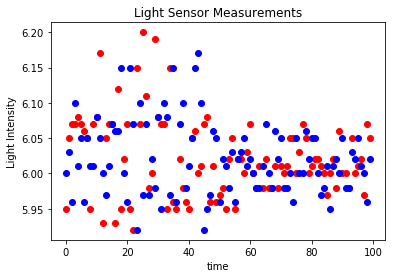

In [4]:
data = np.loadtxt("light_data.csv", delimiter=",")

# plot
x = np.arange(len(data))
fig = plt.figure()
ax = fig.gca()
ax.set_title("Light Sensor Measurements")
ax.plot(x, data[:, 0], "ro")
ax.plot(x, data[:, 1], "bo")
ax.set_xlabel("time")
ax.set_ylabel("Light Intensity")

## 2. Kalman Filter Model

To setup the Kalman Filter, we need to

1. Define the state and input variables
2. Define a state equation which predicts/estimates the next state (denoted **f**)
3. Define an observation equation, relating the state to our measurements (denoted **h**)

#### 1. State and Input Variables:

| Variable  | Notation  | Length | Description  |
|---|---|---|
| state  | x  | n=2 | state vector, luminance and first derivative of luminance |
| inputs  | NA | 0 | there are no external inputs  |
| measurements  | $z$  | m=2 | measured luminance values of the light sensors  |


#### 2. Process Model:
Our state transition function (or process model), $f$, is a linear equation with additive noise $\sigma=N(0, Q)$. We assume that the current luminance value is equal to the previous luminance plus its derivative. If required, this function can be altered to reflect more information about the envirmonement. 
    
$$ x_{t} = f(x_{t-1}) = A x_{t-1} + \sigma$$ 



\begin{equation}
A = 
\begin{bmatrix}
    1 & 1  \\
    0 & 1  \\
\end{bmatrix}
\end{equation}


#### 3. Observation Model:
The true luminance value is assumed to be equal to each measurement (from the sensors), with added noise $\delta=N(0, R)$. Therefore our observation equation is given below:

$$z = h(x_{t}) = B x_{t} + \delta$$

\begin{equation}
B = 
\begin{bmatrix}
    1 & 0  \\
    1 & 0  \\
\end{bmatrix}
\;
\end{equation}


#### 4. Initialisation:

Once the system has been described, we are left with two linear gaussian equations (one each for estimations and observations). The Kalman Filter is then used to form a weighted sum of each equation, trading off our uncertainty in each model. Therefore, as a system designer we need to establish whether we are more confident in our state estimation equation, or our measurements. We control this using parameters **qval** and **rval**. As observed in the luminance plot above, our measurements are very noisy for sensor B. Therefore we will chose a large rval for sensor B, indicating higher uncertainty about those measurements. 

The [PYNQ-EKF build flow](https://github.com/sfox14/pynq-ekf/blob/master/build/build.md) can be used to generate the bitstream (.bit) and library (.so). It is necessary to build new ".bit" and ".so" files for each new configuration of **n=?** and **m=?**, but not for each application. 


## 3. Implementation:

This notebook supports the HW-SW co-design architecture only. This means that all application specific code is implemented in Python.

<img src="./imgs/hwsw.png" alt="Drawing" width="500"/>

First, instatiate the Light_EKF object. This provides the binding between Python and our KF:

In [5]:
from ekf.light_ekf import Light_EKF

kf = Light_EKF(n=2, m=2, qval=0.01)

We might want to change the initial state vector so that it's closer to the current luminance. Also, if one sensor is observably more noisy than another one, we should model this behaviour by setting the observation covariance matrix (R) appropriately. In this example, sensorB is notably more noisy.

In [6]:
kf.x = np.array([6.0, 0])
kf.R = np.array([[0.1, 0],[0, 1.0]])

Lets check whether the software-only and hardware-software implementations are equivalent. 

In [7]:
res_sw = kf.run_sw(data)
res_hw = kf.run_hw(data)

In [8]:
print("Error: ", (res_sw - kf.toFloat(res_hw)).mean())

Error:  -0.0023566053080810055


We can also run the hardware-software again to make sure they are the same.

In [9]:
kf.xlnk.xlnk_reset()
res_hw_2 = kf.run_hw(data)
print("Equal: ", np.array_equal(res_hw, res_hw_2))

Equal:  True


The plot below shows the Kalman Filter working properly. The two noisy measurements and our estimation model are combined to produce a smoother graph of luminance. This works by trading off our uncertainty in each model.

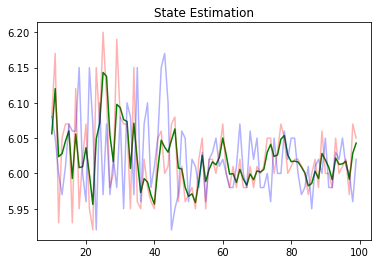

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

#We start plotting after 10 samples, at which point the KF is stable 
plt.figure()
plt.title("State Estimation")
x = np.arange(len(res_sw)) 
plt.plot(x[10:], kf.toFloat(res_hw[10:,0]), "g")
plt.plot(x[10:], data[10:,0], "r", alpha=0.3)
plt.plot(x[10:], data[10:,1], "b", alpha=0.3)
plt.show()

In [11]:
kf.xlnk.xlnk_reset()